In [679]:
# import necessary library
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import re
import numpy as np
import geopandas as gpd
from shapely.geometry import Point # Point class
from shapely.geometry import shape
import networkx as nx
import osmnx as ox
import os 
from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
import shapely.geometry as geom
import shapely.wkt

In [680]:
# Helper Function
def min_distance_ppoly(point, polygon):
    return polygon.distance(point).min()


# Calculate Weekly and Monthly Total Traffic

In [681]:
# Import estimated daily Volume
DV=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_DV1.csv')
DV=DV.drop(['level_0','index'],axis=1)
DV.head()

,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
0,2014.0,E,Thursday,5.0,6191,37.916293,-122.026658,323.429092
1,2014.0,N,Thursday,5.0,6274,37.919106,-122.065131,44.209732
2,2014.0,S,Thursday,5.0,6002,37.916497,-122.027719,51.190216
3,2014.0,S,Thursday,5.0,6127,37.917992,-122.065518,44.209732
4,2014.0,S,Thursday,5.0,6192,37.884941,-122.077718,20.941452


In [682]:
check=DV.loc[DV['TDV']==0]
check

,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
1381,2016.0,E,Tuesday,10.0,155814,37.647773,-122.105862,0.0
1382,2016.0,E,Tuesday,10.0,157583,37.737660,-122.187827,0.0
1829,2017.0,E,Thursday,11.0,155517,37.678738,-122.050562,0.0
1862,2017.0,N,Thursday,11.0,155502,37.679466,-122.051132,0.0
1895,2017.0,S,Thursday,10.0,155349,37.573216,-122.055051,0.0
1908,2017.0,S,Wednesday,9.0,156097,37.700623,-122.143895,0.0
1924,2017.0,W,Thursday,11.0,155504,37.678968,-122.051940,0.0
1996,2018.0,E,Tuesday,10.0,155814,37.647773,-122.105862,0.0
2001,2018.0,E,Tuesday,10.0,157583,37.737660,-122.187827,0.0
2215,2018.0,S,Wednesday,10.0,156097,37.700623,-122.143895,0.0


In [683]:
DV.isnull().sum()

year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

In [684]:
# import pop, CBD and Strava
stv=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Sc_Stv_pop_CBD.csv')
stv=stv.rename(columns={'tdg_id':'matched_seg_id'})
stv.tail(2)

,Unnamed: 0.1,matched_seg_id,year,Unnamed: 0,ID,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
5702,5702,66187.0,2014.0,5478,Eric_Fischer893,S,34.266245,-118.313146,308135633.0,13291814.0,NaN,NaN,NaN,NaN,0.0,POINT (155306.06124027242 -415248.5251424038),5304.864322
5703,5703,64988.0,2014.0,5571,Eric_Fischer986,E,34.066455,-118.469556,307724323.0,203650462.0,NaN,NaN,NaN,NaN,0.0,POINT (141264.8749155821 -437655.1388520058),6901.823725


In [685]:
stv1=stv[['matched_seg_id','year','stv_rec_ratio','popden']]
stv1.shape

(5704, 4)

In [686]:
DV1=pd.merge(DV,stv1, left_on=['matched_seg_id','year'],right_on=['matched_seg_id','year'],how='inner')
DV1.shape

(7926, 10)

In [687]:
DV['matched_seg_id'].nunique(),stv['matched_seg_id'].nunique(),DV1['matched_seg_id'].nunique()

(3533, 3608, 3532)

In [688]:
# Now find the short term sites that did not match
common = stv.merge(DV,on=['matched_seg_id', 'year'])
ch=stv[(~stv.matched_seg_id.isin(common.matched_seg_id))]
ch.head()

,Unnamed: 0.1,matched_seg_id,year,Unnamed: 0,ID,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
49,49,5909.0,2014.0,49,WC12,N,37.901597,-122.060658,309729214.0,697808495.0,375.0,45.0,330.0,NaN,0.880000,POINT (-180939.03470852147 -10792.114636834245),5677.316051
124,124,111375.0,2014.0,124,SLO_Co99,S,35.449348,-120.905954,308323712.0,867731945.0,3050.0,20.0,3030.0,NaN,0.993443,POINT (-82157.67138367904 -284895.3626244436),367.863889
143,143,6022.0,2014.0,143,WC16,N,37.885501,-122.077831,309726076.0,316338049.0,1730.0,230.0,1500.0,NaN,0.867052,POINT (-182485.8918022544 -12548.073180789128),3924.990637
648,648,135644.0,2015.0,120,Miovision176,N,38.679062,-121.752932,310712694.0,617735651.0,15.0,0.0,15.0,NaN,1.000000,POINT (-152324.28760139478 75074.90131468512),3953.094742
656,656,32221.0,2015.0,128,Miovision306,S,40.412460,-120.642414,313845125.0,7920223.0,55.0,0.0,55.0,NaN,1.000000,POINT (-54521.44497455163 266455.4225359261),876.813749


In [689]:
ch['matched_seg_id'].unique()

array([  5909., 111375.,   6022., 135644.,  32221.,  32226.,  32133.,
       102772., 103137., 103124., 103238.,  14283.,  44460.,  44469.,
       103004., 103005., 103475., 103478., 102936., 102930.,   6265.,
         5913.,   6224., 103463., 103462.,  28989.,  79886., 103171.,
       103167., 103218., 103225., 102826., 103442., 103438., 103128.,
       103579., 102773., 103158., 103555., 103523., 103337., 103288.,
       103199., 103202., 103198.,  89758.,  89790.,  89914., 136340.,
       136343., 136385., 136497., 136496., 136488., 136470., 136492.,
       136487., 136281., 136485., 135866.,  89982., 136382., 136381.,
         6019., 136256., 136407.,  89709.,   6243., 136386., 102845.,
       103263., 103119., 103197.,   5811., 102939., 103323.])

In [690]:
# Lets separate sites that have Strava RR 
DV1['popden'].isnull().sum(),DV1['stv_rec_ratio'].isnull().sum()
# it seems 13 sites hass popden missing or zero pop density and 3673  have missing SRR

(0, 0)

In [691]:
DV1['popden'].fillna(1, inplace=True)

In [692]:
DV1p1=DV1.loc[DV1['stv_rec_ratio']>=0]
DV1p2=DV1[DV1['stv_rec_ratio'].isnull()]

In [693]:
DV1.shape,DV1p1.shape,DV1p2.shape 

((7926, 10), (7926, 10), (0, 10))

In [694]:
# Now estimate SRR using the formula.
# a=0.96967
# b=-0.00303
# c=0.02395
# DV1p2['stv_rec_ratio']=a+b*np.sqrt(DV1p2['popden'])+c*np.log(DV1p2['CBD Distance'])
# DV1p2.head()

In [695]:
# now combine with rest of the data that have already SRR
DV3=DV1p1
DV3.shape

(7926, 10)

In [696]:
# Now calculate the WWI index using WWI= 0.54311-0.04492* ln(population Density) + 0.60716 *〖"(Strava Recreational Ratio)" 〗^𝟐
a=0.54311
b=-0.04492
c=0.60716
DV3['WWI']=a+b*np.log(DV3['popden'])+c*np.power(DV3['stv_rec_ratio'],2)

In [697]:
# Split the data by WWI threshold to apply DOW factor
w_g1=DV3.loc[DV3['WWI']<=0.40]
w_g2=DV3.loc[DV3['WWI']>0.40]
w_g2.tail(2)

,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV,stv_rec_ratio,popden,WWI
7924,2019.0,W,Saturday,6.0,80666,39.140724,-120.155743,48.103565,0.937500,226.820272,0.833094
7925,2019.0,W,Saturday,7.0,80797,39.237589,-120.028389,229.169103,0.977744,674.983342,0.830905


In [698]:
# read DOW factor
DOW=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Final Factor/Final_DOW_Factor.csv')
DOW.head()

,Unnamed: 0,Day of Week,Average_Group_DOW_Factor,criteria
0,0,Monday,0.157756,WWI<=0.40
1,1,Tuesday,0.172408,WWI<=0.40
2,2,Wednesday,0.168993,WWI<=0.40
3,3,Thursday,0.161938,WWI<=0.40
4,4,Friday,0.145688,WWI<=0.40


In [699]:
DOW_g1=DOW.loc[DOW['criteria']=='WWI<=0.40']
DOW_g2=DOW.loc[DOW['criteria']=='WWI>0.40']

In [700]:
# Calculate weekly Volume for group 1
wg1_DV=pd.merge(w_g1,DOW_g1, on=['Day of Week'], how='inner')
wg1_DV1=pd.DataFrame({'agge_Weekly_Volume' : wg1_DV.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['TDV'].sum()}).reset_index()
wg1_DV1f=pd.DataFrame({'agge_factor' : wg1_DV.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['Average_Group_DOW_Factor'].sum()}).reset_index()
wg1_DV1r=pd.merge(wg1_DV1,wg1_DV1f, on=['year','Leg','month','matched_seg_id','Lat','Long'], how='inner')
wg1_DV1r['Weekly_Volume']=wg1_DV1r['agge_Weekly_Volume']/wg1_DV1r['agge_factor']
wg1_DV1rf=pd.DataFrame({'TWV' : wg1_DV1r.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()

In [701]:
c=wg1_DV.loc[wg1_DV['TDV']==0]
c1=wg1_DV1.loc[wg1_DV1['agge_Weekly_Volume']==0]
c.shape,c1.shape

((5, 14), (5, 7))

In [702]:
# Calculate weekly Volume for group 2
wg2_DV=pd.merge(w_g2,DOW_g2, on=['Day of Week'], how='inner')
wg2_DV2=pd.DataFrame({'agge_Weekly_Volume' : wg2_DV.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['TDV'].sum()}).reset_index()
wg2_DV2f=pd.DataFrame({'agge_factor' : wg2_DV.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['Average_Group_DOW_Factor'].sum()}).reset_index()
wg2_DV2r=pd.merge(wg2_DV2,wg2_DV2f, on=['year','Leg','month','matched_seg_id','Lat','Long'], how='inner')
wg2_DV2r['Weekly_Volume']=wg2_DV2r['agge_Weekly_Volume']/wg2_DV2r['agge_factor']
wg2_DV2rf=pd.DataFrame({'TWV' : wg2_DV2r.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()

In [703]:
c=wg2_DV.loc[wg2_DV['TDV']==0]
c1=wg2_DV2.loc[wg2_DV2['agge_Weekly_Volume']==0]
c.shape,c1.shape

((21, 14), (21, 7))

In [704]:
wg2_DV.head()

,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV,stv_rec_ratio,popden,WWI,Unnamed: 0,Average_Group_DOW_Factor,criteria
0,2014.0,E,Thursday,5.0,6191,37.916293,-122.026658,323.429092,0.967676,3574.017778,0.744142,3,0.126624,WWI>0.40
1,2014.0,N,Thursday,5.0,6274,37.919106,-122.065131,44.209732,0.793651,6404.168560,0.531838,3,0.126624,WWI>0.40
2,2014.0,S,Thursday,5.0,6002,37.916497,-122.027719,51.190216,0.953779,3637.433372,0.727140,3,0.126624,WWI>0.40
3,2014.0,S,Thursday,5.0,6127,37.917992,-122.065518,44.209732,0.740741,6241.750126,0.483700,3,0.126624,WWI>0.40
4,2014.0,S,Thursday,5.0,6192,37.884941,-122.077718,20.941452,0.943190,3911.200091,0.711684,3,0.126624,WWI>0.40


In [705]:
# Apply factor to obtain weekly Total Volume Volume
# wg1_DV=pd.merge(w_g1,DOW_g1, on=['Day of Week'], how='inner')
# wg1_DV['Weekly_Volume']=wg1_DV['TDV']/wg1_DV['Average_Group_DOW_Factor']
# wg1_DV1=pd.DataFrame({'TWV' : wg1_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()
# wg2_DV=pd.merge(w_g2,DOW_g2, on=['Day of Week'], how='inner')
# wg2_DV['Weekly_Volume']=wg2_DV['TDV']/wg2_DV['Average_Group_DOW_Factor']
# wg2_DV2=pd.DataFrame({'TWV' : wg2_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()


In [706]:
# c=wg2_DV2.loc[wg2_DV2['TWV']==0]
# c1=wg1_DV1.loc[wg1_DV1['TWV']==0]
# c.shape,c1.shape

In [707]:
# combine these three group of estimated daily volume together
WV=pd.concat([wg1_DV1rf,wg2_DV2rf],axis=0).reset_index()
WV.head()

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV
0,0,2014.0,E,1.0,50923,34.047600,-118.260680,7115.097823
1,1,2014.0,E,1.0,50974,34.040341,-118.267467,8327.898588
2,2,2014.0,E,1.0,52877,34.021631,-118.279393,7115.097823
3,3,2014.0,E,1.0,52997,34.037265,-118.269459,6064.003826
4,4,2014.0,E,1.0,53084,34.036725,-118.268227,2223.468070


In [708]:
WV['matched_seg_id'].nunique()

3532

In [709]:
wg2_DV.isnull().sum()

year                        0
Leg                         0
Day of Week                 0
month                       0
matched_seg_id              0
Lat                         0
Long                        0
TDV                         0
stv_rec_ratio               0
popden                      0
WWI                         0
Unnamed: 0                  0
Average_Group_DOW_Factor    0
criteria                    0
dtype: int64

In [710]:
# Now divide TWV by 7 to get the weekley average volume
WV['AWV']=WV['TWV']/7
WV['year'] = WV['year'].apply(np.int64)
WV['month'] = WV['month'].apply(np.int64)
WV.head()

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV
0,0,2014,E,1,50923,34.047600,-118.260680,7115.097823,1016.442546
1,1,2014,E,1,50974,34.040341,-118.267467,8327.898588,1189.699798
2,2,2014,E,1,52877,34.021631,-118.279393,7115.097823,1016.442546
3,3,2014,E,1,52997,34.037265,-118.269459,6064.003826,866.286261
4,4,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296


In [711]:
# Now calculate the number of days in data collection month and multiple average weekly volume (AWV) to get monthly total volume
# create dummy day column to get the date and days in month
WV['day']=1
cols=["year","month","day"]
WV['date'] = WV[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
WV['date'] = pd.to_datetime(WV['date'], errors='coerce')
WV['days_in_month'] = WV['date'].dt.days_in_month
WV.head()

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month
0,0,2014,E,1,50923,34.047600,-118.260680,7115.097823,1016.442546,1,2014-01-01,31
1,1,2014,E,1,50974,34.040341,-118.267467,8327.898588,1189.699798,1,2014-01-01,31
2,2,2014,E,1,52877,34.021631,-118.279393,7115.097823,1016.442546,1,2014-01-01,31
3,3,2014,E,1,52997,34.037265,-118.269459,6064.003826,866.286261,1,2014-01-01,31
4,4,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296,1,2014-01-01,31


In [712]:
WV['MTT']=WV['AWV']*WV['days_in_month']
WV['MTT'].describe()

count      4742.000000
mean       5609.799988
std       10038.475848
min           0.000000
25%        1144.704081
50%        2658.091843
75%        6083.221631
max      224125.915786
Name: MTT, dtype: float64

In [713]:
WV.isnull().sum()

index             0
year              0
Leg               0
month             0
matched_seg_id    0
Lat               0
Long              0
TWV               0
AWV               0
day               0
date              0
days_in_month     0
MTT               0
dtype: int64

In [714]:
check=WV.loc[WV['MTT']==0]
check

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT
602,602,2016,N,10,150133,37.568146,-121.973536,0.0,0.0,1,2016-10-01,31,0.0
900,900,2017,N,11,155319,37.542417,-122.047910,0.0,0.0,1,2017-11-01,30,0.0
976,976,2017,W,9,157528,37.773863,-122.221284,0.0,0.0,1,2017-09-01,30,0.0
1304,1304,2018,W,10,157375,37.793646,-122.227237,0.0,0.0,1,2018-10-01,31,0.0
1305,1305,2018,W,10,157528,37.773863,-122.221284,0.0,0.0,1,2018-10-01,31,0.0
2619,1203,2016,E,10,155814,37.647773,-122.105862,0.0,0.0,1,2016-10-01,31,0.0
2630,1214,2016,E,10,157583,37.737660,-122.187827,0.0,0.0,1,2016-10-01,31,0.0
2910,1494,2016,N,10,156921,37.806382,-122.250017,0.0,0.0,1,2016-10-01,31,0.0
3566,2150,2017,E,11,155517,37.678738,-122.050562,0.0,0.0,1,2017-11-01,30,0.0
3567,2151,2017,E,11,155614,37.671424,-122.082380,0.0,0.0,1,2017-11-01,30,0.0


<AxesSubplot: >

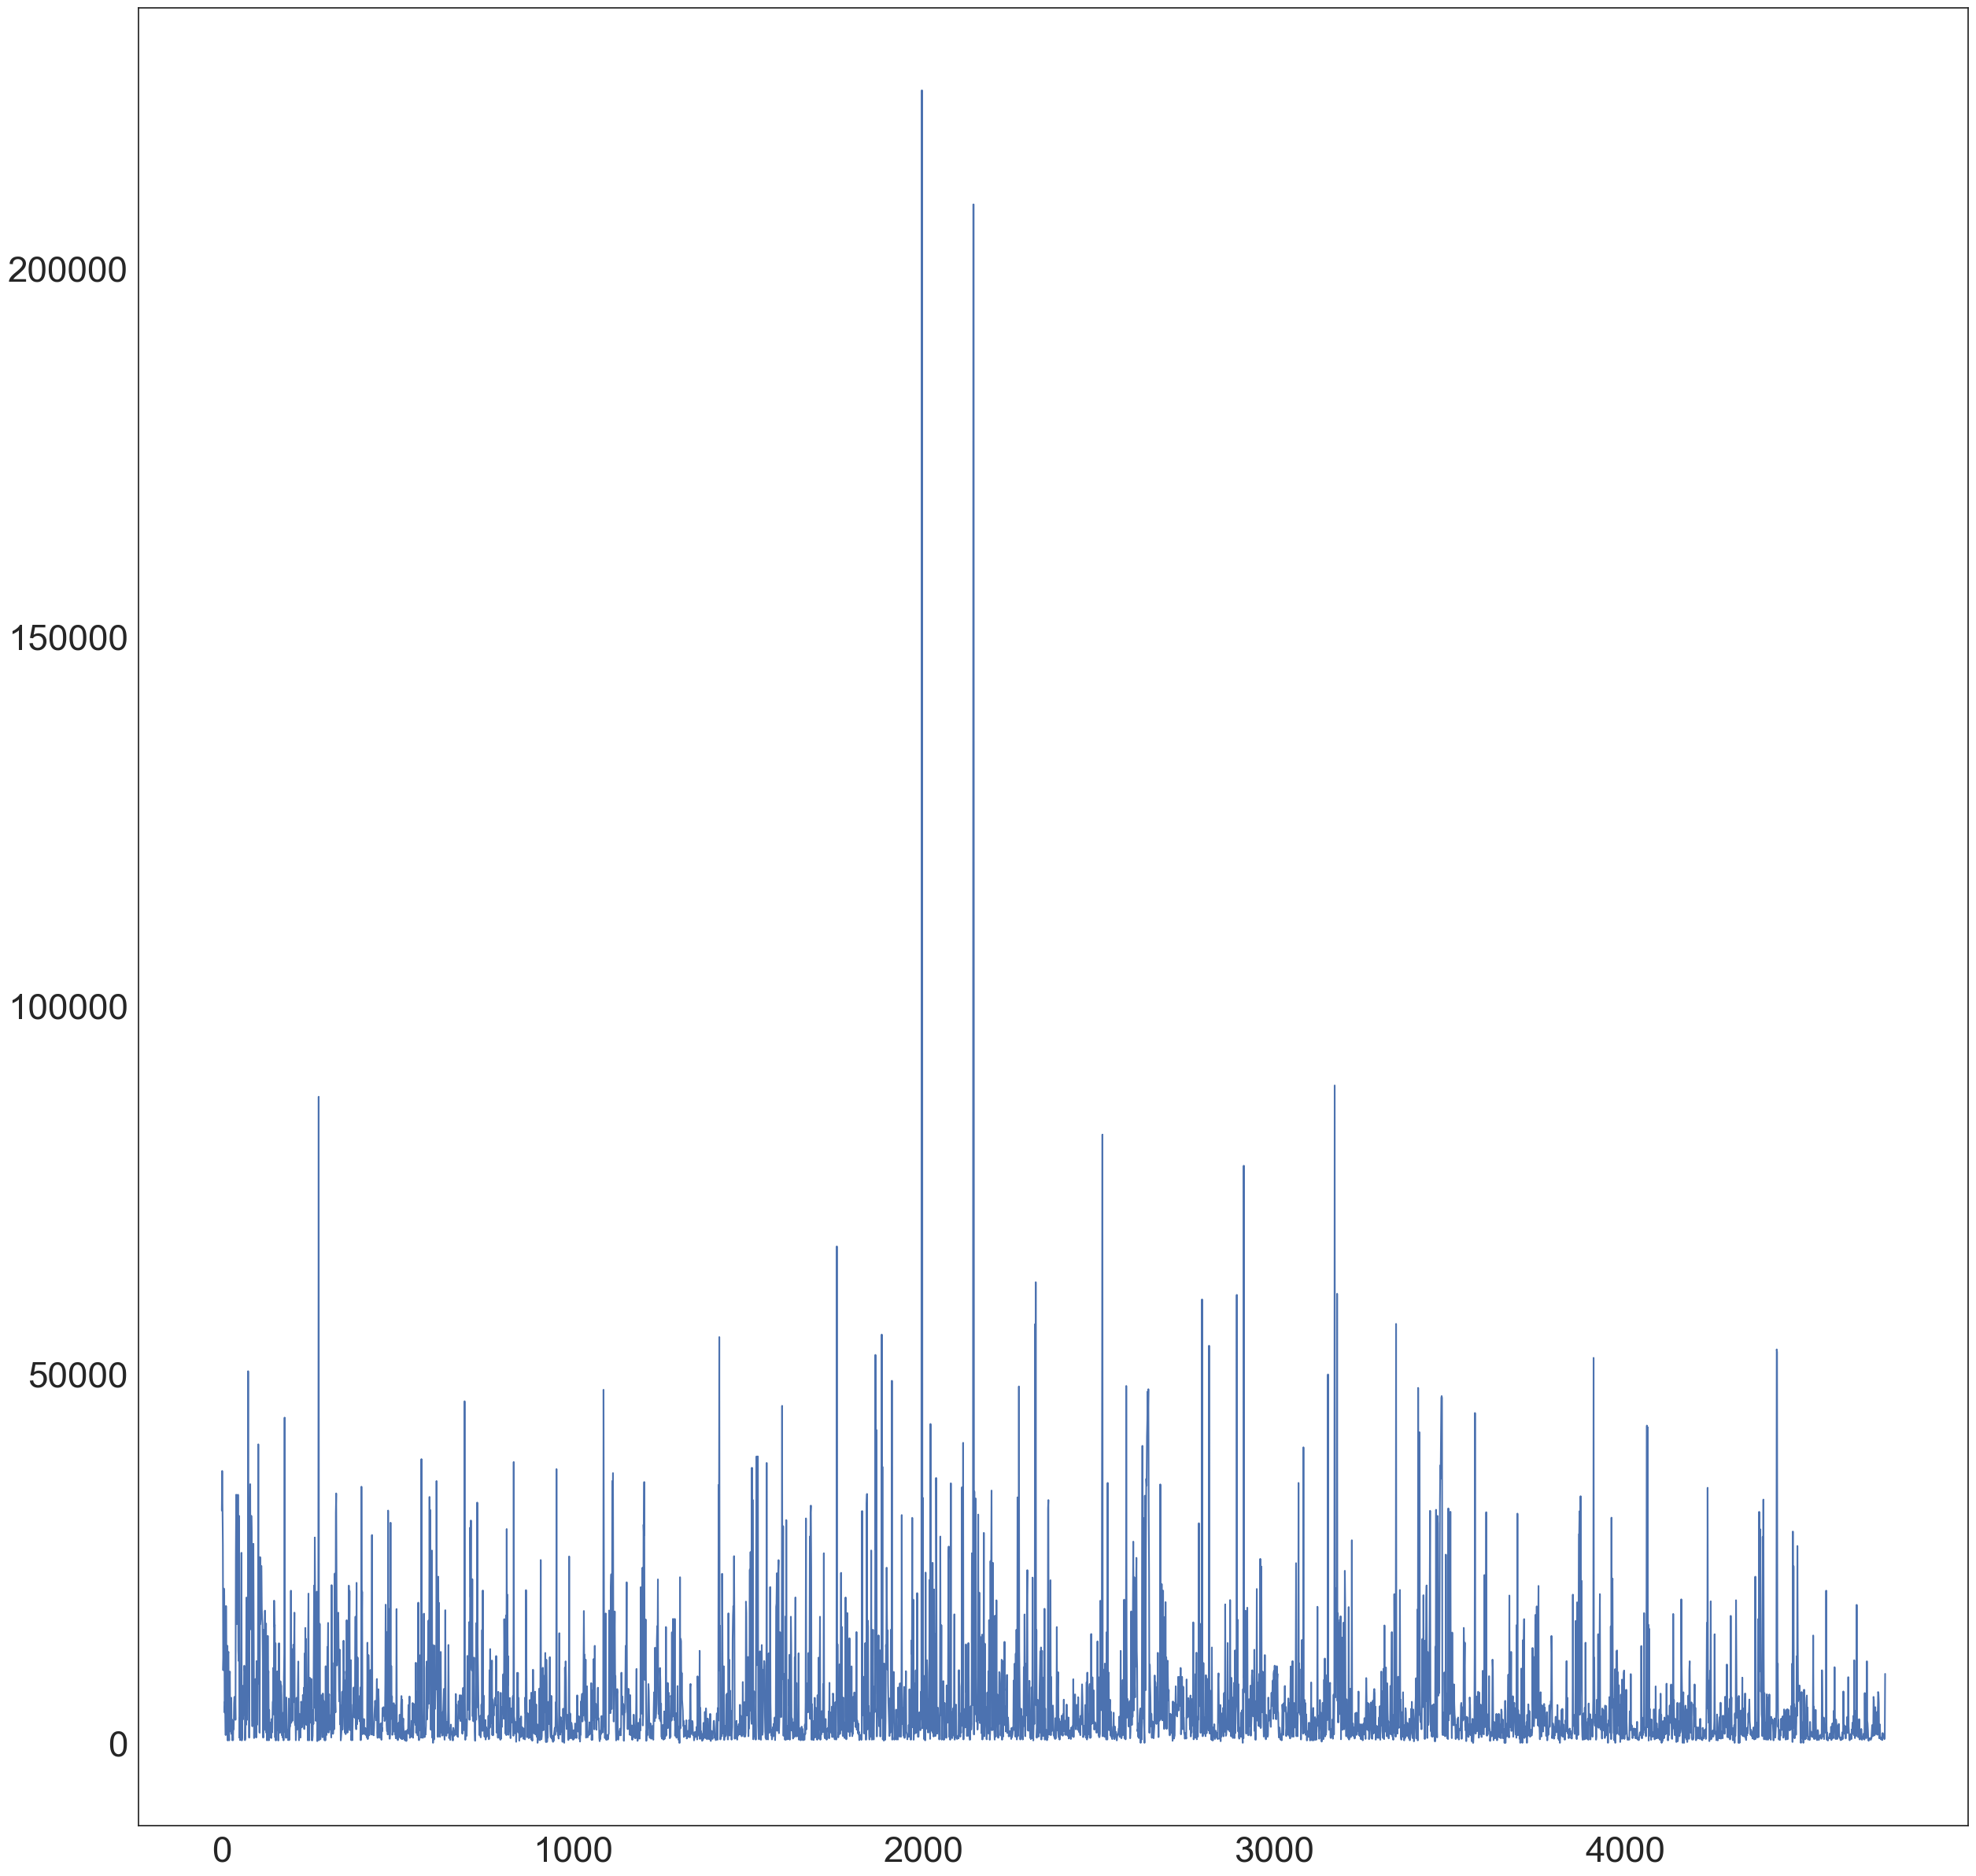

In [715]:
WV['MTT'].plot()

In [716]:
check=WV.loc[WV['MTT']>200000]
check

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT
1995,579,2015,N,7,64682,33.982118,-118.467676,50609.077758,7229.868251,1,2015-07-01,31,224125.915786
1996,580,2015,N,7,64850,33.987501,-118.472123,50609.077758,7229.868251,1,2015-07-01,31,224125.915786
2142,726,2015,S,7,64618,33.979071,-118.465131,47115.354442,6730.764920,1,2015-07-01,31,208653.712527
2143,727,2015,S,7,64854,33.987236,-118.471897,47115.354442,6730.764920,1,2015-07-01,31,208653.712527


# Now Estimate Annual Total Traffic

In [717]:
# read the moy factor
MOY=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Final Factor/Final_MOY_Factor.csv')
MOY.head()

,Unnamed: 0,month,Average_Group_MOY_Factor,Criteria
0,0,1,0.067719,seasonal_factor<=2.4
1,1,2,0.071112,seasonal_factor<=2.4
2,2,3,0.080148,seasonal_factor<=2.4
3,3,4,0.087425,seasonal_factor<=2.4
4,4,5,0.091053,seasonal_factor<=2.4


In [718]:
MOY['Criteria'].unique()

array(['seasonal_factor<=2.4', '2.4<seasonal_factor<=5',
       'seasonal_factor>5'], dtype=object)

In [719]:
# Now split the data by group
moy_g1=MOY.loc[MOY['Criteria']=='seasonal_factor<=2.4']
moy_g2=MOY.loc[MOY['Criteria']=='2.4<seasonal_factor<=5']
moy_g3=MOY.loc[MOY['Criteria']=='seasonal_factor>5']
moy_g3.head(2)

,Unnamed: 0,month,Average_Group_MOY_Factor,Criteria
24,0,1,0.021449,seasonal_factor>5
25,1,2,0.018644,seasonal_factor>5


In [720]:
# Calculate the seasonality factor and check how many sites have data to calculate it
# get June/July/August Data
dos678=DV[(DV['month']>5) &(DV['month']<9)]
dos678=dos678[['matched_seg_id','year','Leg','TDV']]
dos678c=pd.DataFrame({'Average Daily Count678' : dos678.groupby(['matched_seg_id','year','Leg'])['TDV'].mean()}).reset_index()
dos678c.head()

,matched_seg_id,year,Leg,Average Daily Count678
0,6447,2014.0,S,30.070687
1,6893,2015.0,N,71.779543
2,7119,2017.0,E,64.427432
3,7175,2017.0,N,1190.231671
4,7211,2016.0,W,152.579892


In [721]:
# get December/January/February Data
dos12=DV.loc[DV['month']==12]
dos1=DV.loc[DV['month']==1]
dos3=DV.loc[DV['month']==2]
dos1213=pd.concat([dos12,dos1,dos3],axis=0)
dos1213=dos1213[['matched_seg_id','year',"Leg",'TDV']]
dos12131=pd.DataFrame({'Average Daily Count12131' : dos1213.groupby(['matched_seg_id','year','Leg'])['TDV'].mean()}).reset_index()
dos12131.head()

,matched_seg_id,year,Leg,Average Daily Count12131
0,2183,2018.0,N,23.948430
1,2185,2018.0,W,28.837404
2,2186,2018.0,E,42.576426
3,5820,2019.0,S,72.248933
4,5849,2014.0,W,42.191758


In [722]:
seasonal_data=pd.merge(dos12131,dos678c, left_on=['matched_seg_id','year','Leg'],right_on=['matched_seg_id','year','Leg'],how='inner')
seasonal_data['seasonal_factor']=seasonal_data['Average Daily Count678']/seasonal_data['Average Daily Count12131']
seasonal_data=seasonal_data[['matched_seg_id','year','Leg','seasonal_factor']]
seasonal_data.head()

,matched_seg_id,year,Leg,seasonal_factor


In [723]:
# It seems none of the sites have data to calculate the seasonality, therefore used geohrahic classification to assign the
#seasonality group. Use the closest distance to assign the seasonal group
g1=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Revised_Seasonality/Group1.shp')
g1['group']='seasonal_factor<=2.4'
g2=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Revised_Seasonality/Group2.shp')
g2['group']='2.4<seasonal_factor<=5'
g3=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Revised_Seasonality/Group3.shp')
g3['group']='seasonal_factor>5'
# combine all
s_g=pd.concat([g1,g2,g3],axis=0)
#s_g['group'] = s_g['group'].apply(np.int64)
s_g.head()

,Field1,ID,latitude,longitude,location,road,city,county,state,country,Average_se,geometry,group
0,0,671,37.791160,-122.459440,urban,Bay Area Ridge Trail,San Francisco,None,California,United States,1.268874,POINT (-122.45944 37.79116),seasonal_factor<=2.4
1,1,1127,37.796165,-122.419490,urban,Broadway,San Francisco,None,California,United States,1.012863,POINT (-122.41949 37.79617),seasonal_factor<=2.4
2,2,2415,37.774200,-122.436295,urban,Fell Street,San Francisco,None,California,United States,1.407406,POINT (-122.43629 37.77420),seasonal_factor<=2.4
3,3,2694,33.683254,-117.662080,urban,Torino Drive,None,Orange County,California,United States,1.359999,POINT (-117.66208 33.68325),seasonal_factor<=2.4
4,4,2695,33.672590,-117.651860,urban,Serrano Road,None,Orange County,California,United States,1.515797,POINT (-117.65186 33.67259),seasonal_factor<=2.4


In [724]:
s_g.groupby(['group'])['ID'].count()

group
2.4<seasonal_factor<=5      6
seasonal_factor<=2.4      152
seasonal_factor>5           6
Name: ID, dtype: int64

In [725]:
s_g.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [726]:
WV1 = gpd.GeoDataFrame(WV, geometry=gpd.points_from_xy(WV.Long, WV.Lat))
WV1.head()

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry
0,0,2014,E,1,50923,34.047600,-118.260680,7115.097823,1016.442546,1,2014-01-01,31,31509.718929,POINT (-118.26068 34.04760)
1,1,2014,E,1,50974,34.040341,-118.267467,8327.898588,1189.699798,1,2014-01-01,31,36880.693747,POINT (-118.26747 34.04034)
2,2,2014,E,1,52877,34.021631,-118.279393,7115.097823,1016.442546,1,2014-01-01,31,31509.718929,POINT (-118.27939 34.02163)
3,3,2014,E,1,52997,34.037265,-118.269459,6064.003826,866.286261,1,2014-01-01,31,26854.874088,POINT (-118.26946 34.03726)
4,4,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296,1,2014-01-01,31,9846.787165,POINT (-118.26823 34.03673)


In [727]:
crs = {'init': 'epsg:4326'}
WV2 = gpd.GeoDataFrame(WV1, crs=crs, geometry = 'geometry')
WV2.head()

C:\Users\mmmiah\AppData\Local\ESRI\conda\envs\geo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry
0,0,2014,E,1,50923,34.047600,-118.260680,7115.097823,1016.442546,1,2014-01-01,31,31509.718929,POINT (-118.26068 34.04760)
1,1,2014,E,1,50974,34.040341,-118.267467,8327.898588,1189.699798,1,2014-01-01,31,36880.693747,POINT (-118.26747 34.04034)
2,2,2014,E,1,52877,34.021631,-118.279393,7115.097823,1016.442546,1,2014-01-01,31,31509.718929,POINT (-118.27939 34.02163)
3,3,2014,E,1,52997,34.037265,-118.269459,6064.003826,866.286261,1,2014-01-01,31,26854.874088,POINT (-118.26946 34.03726)
4,4,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296,1,2014-01-01,31,9846.787165,POINT (-118.26823 34.03673)


In [728]:
# project the co-ordinate
WV2_proj = WV2.to_crs(epsg=3310).reset_index()
s_g_proj = s_g.to_crs(epsg=3310).reset_index()

In [729]:
def nearest_point(point, point2):
    idx = point2.geometry.distance(point).idxmin()
    return point2.loc[idx,'group']

In [730]:
WV2_proj['group'] = WV2_proj.geometry.apply(nearest_point, point2=s_g_proj)
WV2_proj.head()

,level_0,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
0,0,0,2014,E,1,50923,34.047600,-118.260680,7115.097823,1016.442546,1,2014-01-01,31,31509.718929,POINT (160580.776 -439413.598),seasonal_factor<=2.4
1,1,1,2014,E,1,50974,34.040341,-118.267467,8327.898588,1189.699798,1,2014-01-01,31,36880.693747,POINT (159968.995 -440230.143),seasonal_factor<=2.4
2,2,2,2014,E,1,52877,34.021631,-118.279393,7115.097823,1016.442546,1,2014-01-01,31,31509.718929,POINT (158905.642 -442325.360),seasonal_factor<=2.4
3,3,3,2014,E,1,52997,34.037265,-118.269459,6064.003826,866.286261,1,2014-01-01,31,26854.874088,POINT (159791.346 -440574.691),seasonal_factor<=2.4
4,4,4,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296,1,2014-01-01,31,9846.787165,POINT (159906.171 -440632.482),seasonal_factor<=2.4


In [731]:
# Now split the data by group
m_g1=WV2_proj.loc[WV2_proj['group']=='seasonal_factor<=2.4']
m_g2=WV2_proj.loc[WV2_proj['group']=='2.4<seasonal_factor<=5']
m_g3=WV2_proj.loc[WV2_proj['group']=='seasonal_factor>5']
m_g3.head(2)

,level_0,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
191,191,191,2015,E,8,8904,38.87892,-120.019933,1357.058416,193.865488,1,2015-08-01,31,6009.830129,POINT (-1726.986 95881.088),seasonal_factor>5
192,192,192,2015,E,9,8904,38.87892,-120.019933,86.612514,12.373216,1,2015-09-01,30,371.196487,POINT (-1726.986 95881.088),seasonal_factor>5


In [732]:
# Calculate Annual Volume for group 1
mg1_DV=pd.merge(m_g1,moy_g1, on=['month'], how='inner')
mg1_DV1=pd.DataFrame({'agge_monthly_Volume' : mg1_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['MTT'].sum()}).reset_index()
mg1_DV1f=pd.DataFrame({'agge_factor' : mg1_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Average_Group_MOY_Factor'].sum()}).reset_index()
mg1_DV1r=pd.merge(mg1_DV1,mg1_DV1f, on=['year','Leg','matched_seg_id','Lat','Long'], how='inner')
mg1_DV1r['Annual_Volume']=mg1_DV1r['agge_monthly_Volume']/mg1_DV1r['agge_factor']
mg1_DV1rf=pd.DataFrame({'ATT' : mg1_DV1r.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()

In [733]:
mg1_DV.shape,mg1_DV1.shape

((4572, 19), (4490, 6))

In [734]:
c=mg1_DV.loc[mg1_DV['MTT']==0]
c1=mg1_DV1.loc[mg1_DV1['agge_monthly_Volume']==0]
c.shape,c1.shape

((26, 19), (26, 6))

In [735]:
# Calculate Annual Volume for group 1
mg2_DV=pd.merge(m_g2,moy_g2, on=['month'], how='inner')
mg2_DV2=pd.DataFrame({'agge_monthly_Volume' : mg2_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['MTT'].sum()}).reset_index()
mg2_DV2f=pd.DataFrame({'agge_factor' : mg2_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Average_Group_MOY_Factor'].sum()}).reset_index()
mg2_DV2r=pd.merge(mg2_DV2,mg2_DV2f, on=['year','Leg','matched_seg_id','Lat','Long'], how='inner')
mg2_DV2r['Annual_Volume']=mg2_DV2r['agge_monthly_Volume']/mg2_DV2r['agge_factor']
mg2_DV2rf=pd.DataFrame({'ATT' : mg2_DV2r.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()

In [736]:
# Calculate Annual Volume for group 1
mg3_DV=pd.merge(m_g3,moy_g3, on=['month'], how='inner')
mg3_DV3=pd.DataFrame({'agge_monthly_Volume' : mg3_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['MTT'].sum()}).reset_index()
mg3_DV3f=pd.DataFrame({'agge_factor' : mg3_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Average_Group_MOY_Factor'].sum()}).reset_index()
mg3_DV3r=pd.merge(mg3_DV3,mg3_DV3f, on=['year','Leg','matched_seg_id','Lat','Long'], how='inner')
mg3_DV3r['Annual_Volume']=mg3_DV3r['agge_monthly_Volume']/mg3_DV3r['agge_factor']
mg3_DV3rf=pd.DataFrame({'ATT' : mg3_DV3r.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()

In [737]:
# Now apply the MOY factor to get ATT
# Apply factor to obtain daily Volume
# mg1_DV=pd.merge(m_g1,moy_g1, on=['month'], how='inner')
# mg1_DV['Annual_Volume']=mg1_DV['MTT']/mg1_DV['Average_Group_MOY_Factor']
# mg1_DV1=pd.DataFrame({'ATT' : mg1_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
# mg2_DV=pd.merge(m_g2,moy_g2, on=['month'], how='inner')
# mg2_DV['Annual_Volume']=mg2_DV['MTT']/mg2_DV['Average_Group_MOY_Factor']
# mg2_DV2=pd.DataFrame({'ATT' : mg2_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
# mg3_DV=pd.merge(m_g3,moy_g3, on=['month'], how='inner')
# mg3_DV['Annual_Volume']=mg3_DV['MTT']/mg3_DV['Average_Group_MOY_Factor']
# mg3_DV3=pd.DataFrame({'ATT' : mg3_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
# mg3_DV3.head()

In [738]:
# mg1_DV.tail(10)

In [766]:
# combine these three group of estimated Annual volume together
AV=pd.concat([mg1_DV1rf,mg2_DV2rf,mg3_DV3rf],axis=0).reset_index()
AV.ATT = AV.ATT.round()
AV.head()

,index,year,Leg,matched_seg_id,Lat,Long,ATT
0,0,2014,E,6191,37.916293,-122.026658,124231.0
1,1,2014,E,6234,37.885158,-122.077300,17640.0
2,2,2014,E,39019,34.003755,-118.282140,516595.0
3,3,2014,E,41274,33.786472,-118.306741,218978.0
4,4,2014,E,44255,34.090759,-118.308870,261034.0


In [770]:
# bring back the location id
idf=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Processed Data/short_term_clean_data_2014_2019.csv')
idf=idf[['ID',"matched_seg_id"]]
idf1=idf.drop_duplicates(subset=["matched_seg_id"], keep='first')
idf1.shape

(4264, 2)

In [772]:
AV1=pd.merge(AV, idf1, on=['matched_seg_id'], how='inner')
AV1.shape

(4634, 9)

In [773]:
# now check unique location for each year
AV1.groupby(['year'])['ID'].nunique()

year
2014    205
2015    311
2016    581
2017    317
2018    466
2019    229
Name: ID, dtype: int64

In [774]:
AV1['ID'].nunique()

1699

In [767]:
AV=AV.loc[AV['Lat']!=0]
AV['ATT in Million']=AV['ATT']/1000000
AV.head()

,index,year,Leg,matched_seg_id,Lat,Long,ATT,ATT in Million
0,0,2014,E,6191,37.916293,-122.026658,124231.0,0.124231
1,1,2014,E,6234,37.885158,-122.077300,17640.0,0.017640
2,2,2014,E,39019,34.003755,-118.282140,516595.0,0.516595
3,3,2014,E,41274,33.786472,-118.306741,218978.0,0.218978
4,4,2014,E,44255,34.090759,-118.308870,261034.0,0.261034


In [768]:
c=AV.loc[AV['ATT']==0]
c.shape

(26, 8)

In [742]:
AV['ATT in Million'].max()

2.303203

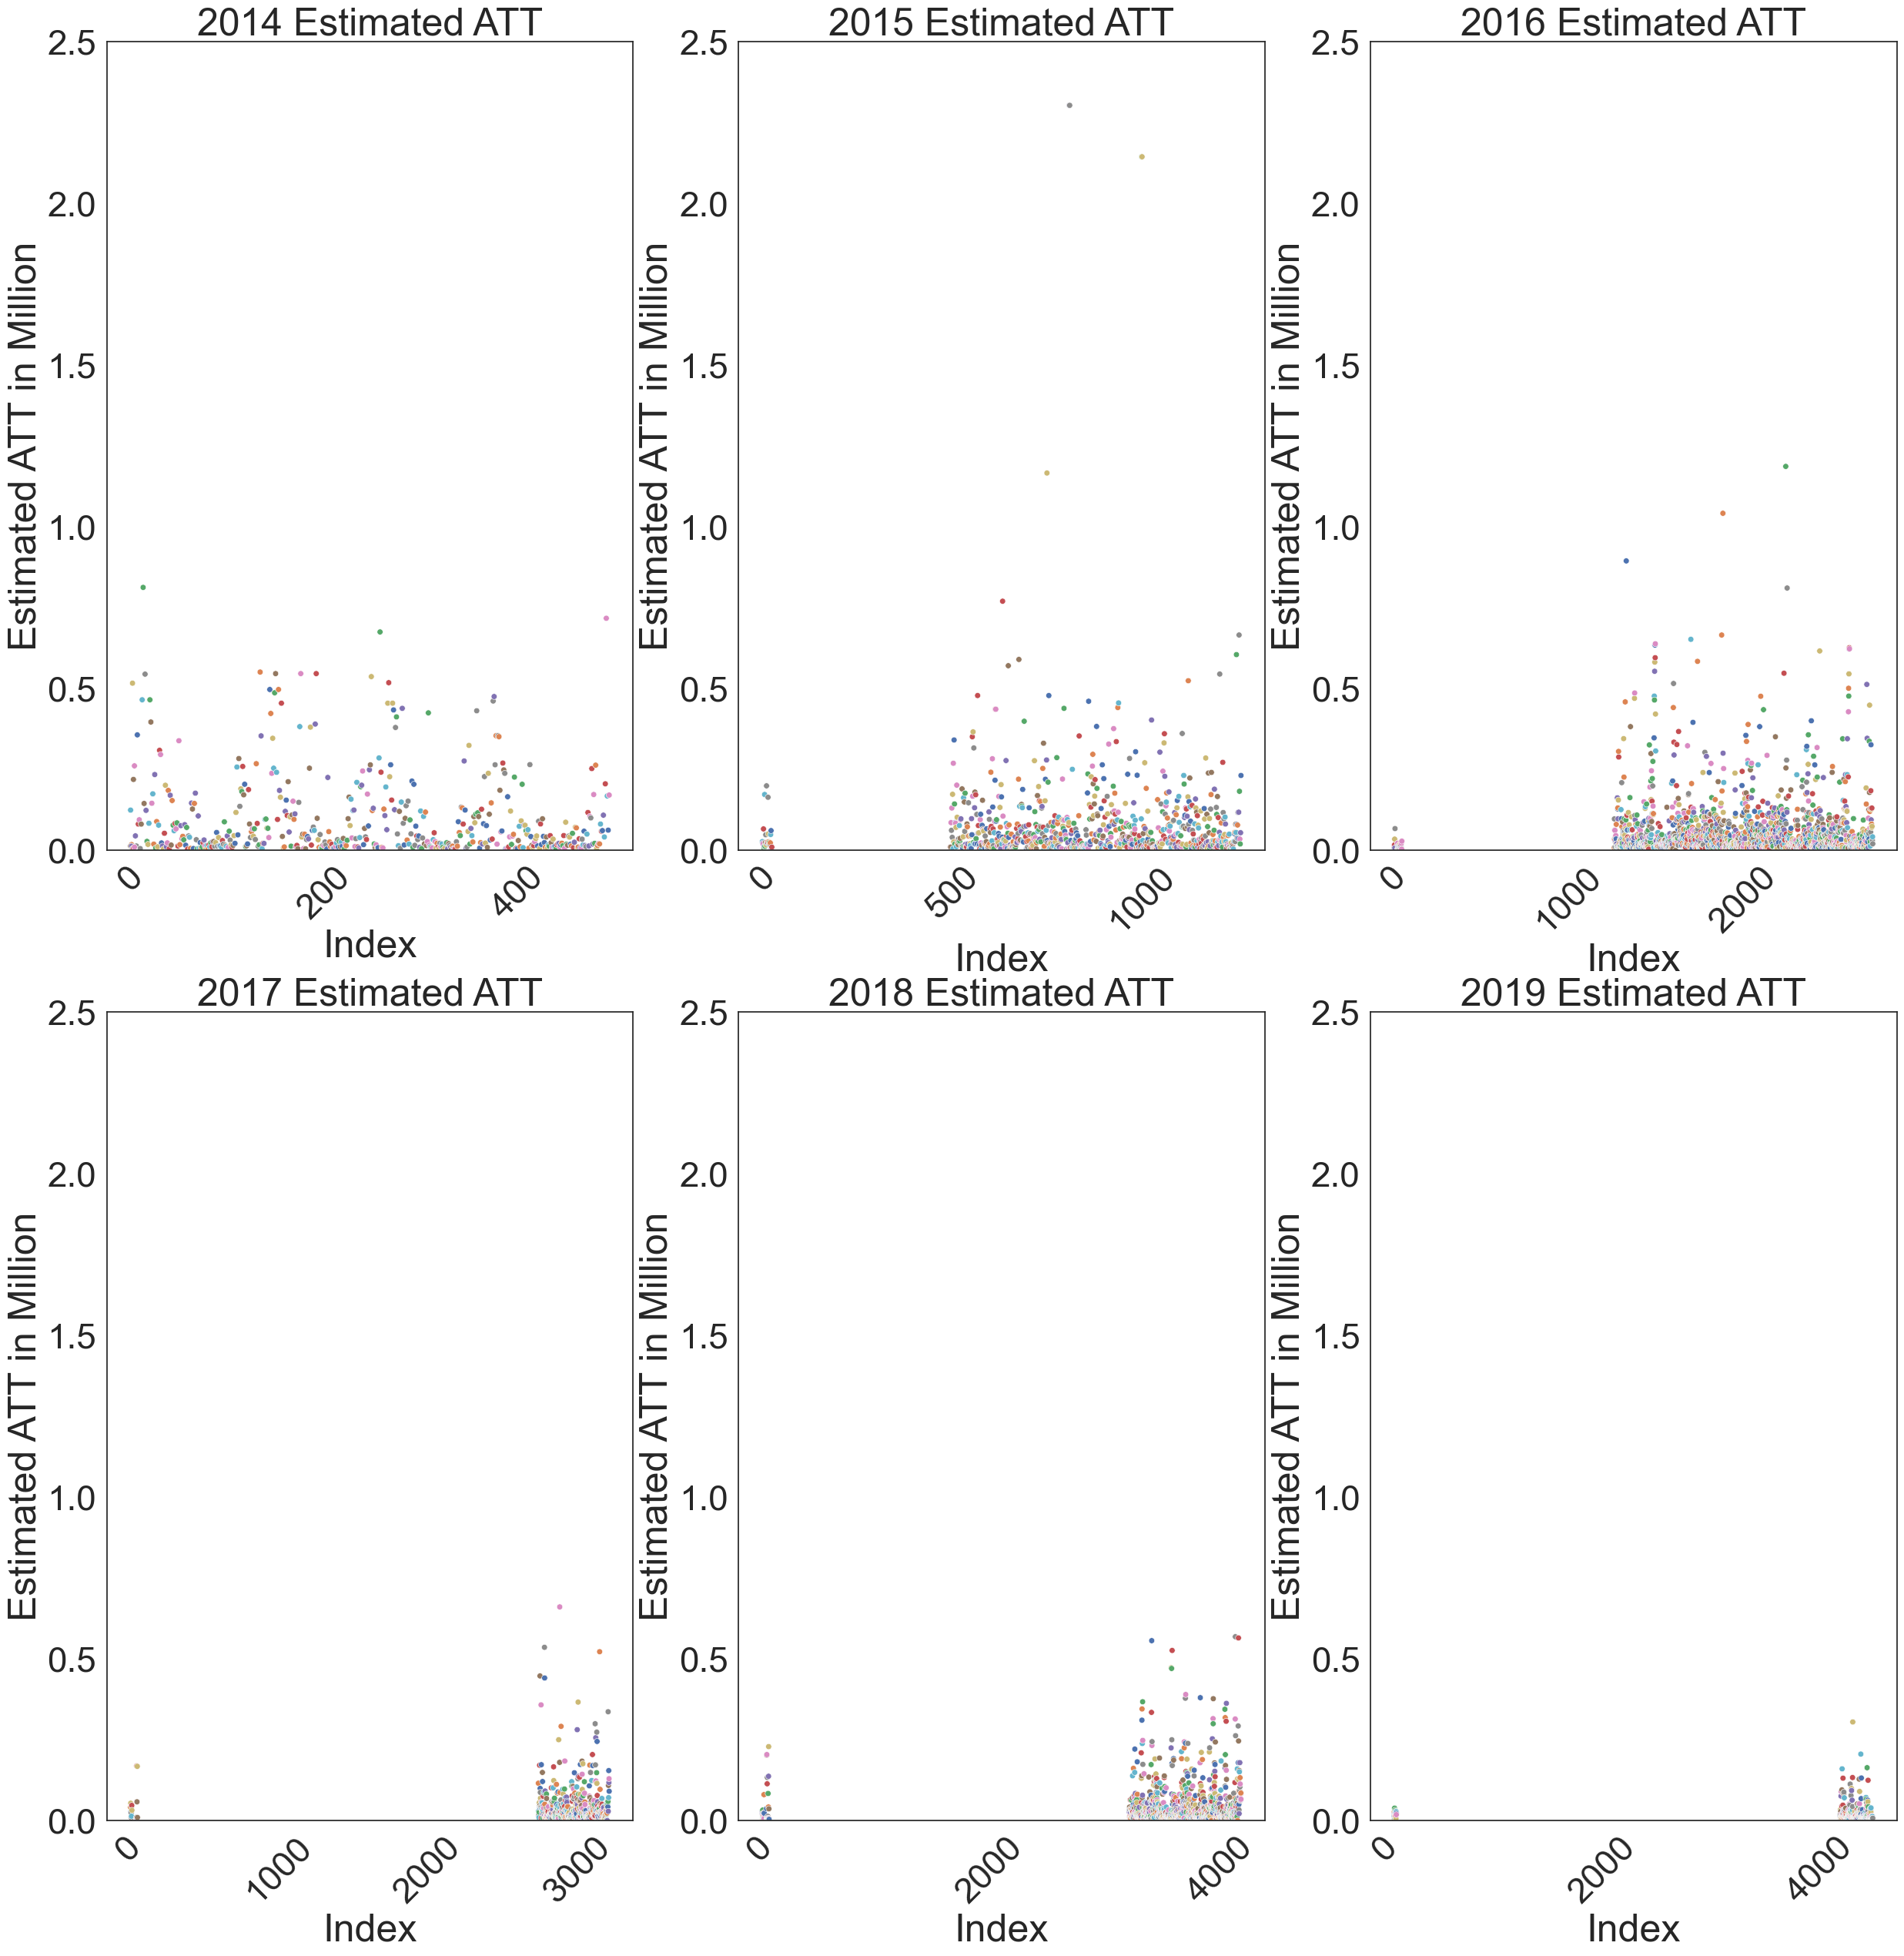

In [743]:
sns.set(rc={'figure.figsize':(30,30)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=3, color_codes=False, rc=None)
#sns.set(font_scale=3.0)
#sns.set_theme(style='white')
import seaborn as sns
d14=AV.loc[AV['year']==2014]
d15=AV.loc[AV['year']==2015]
d16=AV.loc[AV['year']==2016]
d17=AV.loc[AV['year']==2017]
d18=AV.loc[AV['year']==2018]
d19=AV.loc[AV['year']==2019]
fig, ax = plt.subplots(2,3) 

ax1 = sns.scatterplot(x=d14['index'],y=d14['ATT in Million'],hue=d14['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[0,0]) 
plt.xticks(rotation = 'vertical')
ax2 = sns.scatterplot(x=d15['index'],y=d15['ATT in Million'],hue=d15['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[0,1]) 
plt.xticks(rotation = 'vertical')
ax3 = sns.scatterplot(x=d16['index'],y=d16['ATT in Million'],hue=d16['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[0,2]) 
plt.xticks(rotation = 'vertical')
ax4 = sns.scatterplot(x=d17['index'],y=d17['ATT in Million'],hue=d17['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[1,0]) 
plt.xticks(rotation = 'vertical')
ax5 = sns.scatterplot(x=d18['index'],y=d18['ATT in Million'],hue=d18['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[1,1])
plt.xticks(rotation = 'vertical')
ax6 = sns.scatterplot(x=d19['index'],y=d19['ATT in Million'],hue=d19['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[1,2]) 
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax6.get_legend().remove()


ax1.set_ylim([0, 2.5])
ax2.set_ylim([0, 2.5])
ax3.set_ylim([0, 2.5])
ax4.set_ylim([0, 2.5])
ax5.set_ylim([0, 2.5])
ax6.set_ylim([0, 2.5])
ax1.ticklabel_format(style='plain', axis='both')
ax2.ticklabel_format(style='plain', axis='both')
ax3.ticklabel_format(style='plain', axis='both')
ax4.ticklabel_format(style='plain', axis='both')
ax5.ticklabel_format(style='plain', axis='both')
ax6.ticklabel_format(style='plain', axis='both')

ax1.title.set_text('2014 Estimated ATT')
ax2.title.set_text('2015 Estimated ATT')
ax3.title.set_text('2016 Estimated ATT')
ax4.title.set_text('2017 Estimated ATT')
ax5.title.set_text('2018 Estimated ATT')
ax6.title.set_text('2019 Estimated ATT')

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45)

ax1.set_ylabel('Estimated ATT in Million' )
ax1.set_xlabel('Index')
ax2.set_ylabel('Estimated ATT in Million' )
ax2.set_xlabel('Index')
ax3.set_ylabel('Estimated ATT in Million' )
ax3.set_xlabel('Index')
ax4.set_ylabel('Estimated ATT in Million' )
ax4.set_xlabel('Index')
ax5.set_ylabel('Estimated ATT in Million' )
ax5.set_xlabel('Index')
ax6.set_ylabel('Estimated ATT in Million' )
ax6.set_xlabel('Index')
plt.show()

In [744]:
AV.groupby(['year'])['Leg'].count()

year
2014     502
2015     795
2016    1510
2017     493
2018    1013
2019     321
Name: Leg, dtype: int64

In [745]:
AV['Leg'].count()

4634

In [746]:
AV.groupby(['year','Leg'])['ATT'].describe().round()

count      mean       std     min      25%      50%       75%  \
year Leg                                                                  
2014 E    133.0   95445.0  128841.0  3680.0  14883.0  43089.0  127616.0   
     N    122.0  119566.0  148732.0  3852.0  15767.0  49661.0  162446.0   
     S    111.0   99793.0  136369.0  3694.0  11206.0  37956.0  122896.0   
     W    136.0   78900.0  109491.0  3885.0  14670.0  38484.0   87533.0   
2015 E    202.0   81594.0  112436.0  3274.0  16683.0  40974.0   94656.0   
     N    193.0  100402.0  254624.0  2480.0  16563.0  39909.0   92445.0   
     S    199.0   98315.0  226390.0  3683.0  18799.0  41306.0   99816.0   
     W    201.0   72514.0   96056.0  3430.0  17905.0  39870.0   96703.0   
2016 E    390.0   72783.0  115328.0     0.0  15409.0  31332.0   74641.0   
     N    404.0   65311.0   95238.0     0.0  15387.0  37912.0   79153.0   
     S    351.0   70382.0  104778.0  1779.0  17994.0  43405.0   81510.0   
     W    365.0   69043.0  103561.0  2053.0  15648.0  34218.0   69980.0   
2017 E    109.0   55596.0   85768.0     0.0  15105.0  30860.0   55225.0   
     N    142.0   43003.0   68170.0     0.0  12005.0  25978.0   47981.0   
     S    121.0   48650.0   57866.0     0.0  12779.0  26896.0   63440.0   
     W    121.0   54166.0   75387.0     0.0  16970.0  30210.0   50640.0   
2018 E    257.0   52735.0   70984.0     0.0  13613.0  27901.0   59525.0   
     N    277.0   49021.0   74374.0     0.0  10573.0  22271.0   51536.0   
     S    246.0   45636.0   61096.0     0.0  10196.0  23360.0   50064.0   
     W    233.0   54063.0   80002.0     0.0  11679.0  27686.0   60105.0   
2019 E     78.0   25352.0   29409.0  3922.0   8757.0  14374.0   27960.0   
     N     83.0   25749.0   39346.0  3043.0   7773.0  14488.0   27718.0   
     S     80.0   24378.0   30867.0  3840.0   8862.0  15290.0   26162.0   
     W     80.0   21369.0   25284.0  3599.0   7568.0  12366.0   24794.0   

                max  
year Leg             
2014 E     812776.0  
     N     551035.0  
     S     675017.0  
     W     717346.0  
2015 E     770105.0  
     N    2303203.0  
     S    2144205.0  
     W     665596.0  
2016 E     894662.0  
     N    1041928.0  
     S    1186858.0  
     W     626190.0  
2017 E     535647.0  
     N     660656.0  
     S     366274.0  
     W     522134.0  
2018 E     556253.0  
     N     525990.0  
     S     379956.0  
     W     568468.0  
2019 E     159991.0  
     N     304905.0  
     S     205571.0  
     W     163462.0

In [747]:
AV.groupby(['year'])['matched_seg_id'].count()

year
2014     502
2015     795
2016    1510
2017     493
2018    1013
2019     321
Name: matched_seg_id, dtype: int64

In [748]:
AV.groupby(['year'])['matched_seg_id'].nunique()

year
2014     487
2015     784
2016    1449
2017     491
2018     987
2019     307
Name: matched_seg_id, dtype: int64

In [750]:
AV['matched_seg_id'].nunique()

3532

In [751]:
AV.shape

(4634, 8)

In [775]:
# Save the estimation
AV.to_csv('H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_ATT.csv',index=False)

In [776]:
# Now join with independent variables
indv=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Independent Variables/smart4_output_Feb3_slope.csv')
indv.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_3564\274848932.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  indv=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Independent Variables/smart4_output_Feb3_slope.csv')


,segment_id,street_name,county,tdg_id,lrs_cal_id,bikes_proh,bike_facs,int_tdg_id,loc_id,seg_counter,...,adt_amt,truck_adt_amt,rt_lanes_amt,lt_lanes_amt,rt_trav_way_width,rt_i_shd_tot_width,rt_o_shd_tot_width,lt_trav_way_width,lt_i_shd_tot_width,lt_o_shd_tot_width
0,NaN,Emerald Bay Road,El Dorado,8041,0,0,NaN,NaN,NaN,NaN,...,3525.0,NaN,1.0,1.0,12.0,0.0,2.0,12.0,0.0,2.0
1,82664.0,Patrick Creek Road,Del Norte,7027,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Hopland Road,Lake,30797,637,0,NaN,NaN,NaN,NaN,...,1481.0,NaN,1.0,1.0,10.0,0.0,2.0,10.0,0.0,2.0
3,59913.0,Cannon Road,Tehama,129091,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,107762.0,RAMP,San Bernardino,96317,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [777]:
# merge the independent variable with dependent variables
data=pd.merge(AV, indv, left_on=['matched_seg_id'], right_on=['tdg_id'],how='inner')
data.shape

(4634, 174)

In [778]:
# save the final data for modeling
data.to_csv('D:/Bike Exposure/Modeling/Final_data_feb8.csv')

In [780]:
# Also save the shape file
idvs=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Independent Variables/SHS shape file/smart4_final_output_Feb2023.shp')
idvs.head()

,segment_id,street_nam,county,tdg_id,lrs_cal_id,bikes_proh,bike_facs,int_tdg_id,loc_id,seg_counte,...,rt_lanes_a,lt_lanes_a,rt_trav_wa,rt_i_shd_t,rt_o_shd_t,lt_trav_wa,lt_i_shd_t,lt_o_shd_t,Shape_Leng,geometry
0,None,Emerald Bay Road,El Dorado,8041.0,0,0,None,None,None,None,...,1.0,1.0,12.0,0.0,2.0,12.0,0.0,2.0,5416.415456,"LINESTRING Z (752783.636 4315141.964 0.000, 75..."
1,82664,Patrick Creek Road,Del Norte,7027.0,0,0,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4715.913544,"LINESTRING Z (429129.958 4640105.752 0.000, 42..."
2,None,Hopland Road,Lake,30797.0,637,0,None,None,None,None,...,1.0,1.0,10.0,0.0,2.0,10.0,0.0,2.0,1972.574701,"LINESTRING Z (501148.889 4315538.675 0.000, 50..."
3,59913,Cannon Road,Tehama,129091.0,0,0,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6360.197488,"LINESTRING Z (541160.263 4449715.440 0.000, 54..."
4,107762,RAMP,San Bernardino,96317.0,0,0,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187.046843,"LINESTRING Z (1015827.620 3801100.883 0.000, 1..."


In [782]:
# merge the independent variable with dependent variables
data_sh=pd.merge(AV, idvs, left_on=['matched_seg_id'], right_on=['tdg_id'],how='inner')
data_sh.shape

(4634, 175)

In [784]:
idvs.crs

<Derived Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [785]:
crs = {'init': 'epsg:26910'}
gdf_geo = gpd.GeoDataFrame(data_sh, crs=crs, geometry = 'geometry')
gdf_geo.to_file("H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_ATT.shp")

C:\Users\mmmiah\AppData\Local\ESRI\conda\envs\geo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_3564\3206929467.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_geo.to_file("H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_ATT.shp")


# end of the Script